 # Introduction
Author of this code: Peter Kongstad - kongstad25@gmail.com - December 2017   
Student ID: AU484199

This script will extract most current Two-Line Element data on any given object orbiting Earth. The TLE data are imported and scrutinized by modules such as ephem, numpy and then finally plotted by the module matplot and the basemap toolkit. For snapshotting most recent weather data and Google Earth imagery, the selenium module and the google chrome webdriver is utilized. These images are then stored, resized and unnecessary image data is cut from the image. As a final step these 4 images along with orbital parameters are shown in the GUI Tkinter. 
 
############################################################################### 

For info on basemap module see:                                              
http://basemaptutorial.readthedocs.io/en/latest/                             
Note this script is build for python 2.7 and will not work correctly on python 3+     
Need to download and install google chrome webdriver for snapshot to work:

https://sites.google.com/a/chromium.org/chromedriver/home and be put into the
python PATH.
###############################################################################

Lastly the code is based on python 2.7 as instructed for this course. This has lead to the trouble of modules experiencing fall-outs, fonts to appear strange and some linux-machines failing to correctly store the snapshots or/and resizing the images. I strongly advice running this script on a Windows machine with python 2.7, as it will produce the desired outcome.

In [1]:
#%% Imported modules
import ephem
import urllib2
import math
import numpy as np
import matplotlib.pyplot as plt
import time
from mpl_toolkits.basemap import Basemap
from datetime import datetime
#Selenium used for screenshot weather import - remember install ChromeDriver 
from selenium import webdriver
from PIL import Image

Import the TLE from celesttrack website

The following lines contain the category numbers for different satellites

39430 This is for GomX1

25544 This is for ISS

41866 This is for GOES

41765 This is for Tiangong 2.

Meaning that once the category number for Delphini-1 is obtained, this can easily be plotted it

# 1.Importing TLE and deducing the Satellite Coordinates

In [2]:
#Imports the raw html code with the TLE information from celestrak website
response = urllib2.urlopen('https://www.celestrak.com/cgi-bin/TLE.pl?CATNR=25544') # This is for ISS
data = response.read()

The imported data contains excess HTML code, which is undesireable. I remove anything before and after the TLE code, leaving 3 lines of useful data for intepretation 

In [3]:
#Clean up its output, removing html code
sep = '</P'
data2 = str(data.split(sep, 1)[0])
sep = 'RE>'
cleaned = str(data2.split(sep, 1)[1])
print cleaned


ISS (ZARYA)             
1 25544U 98067A   18003.62538194  .00002101  00000-0  38805-4 0  9992
2 25544  51.6406 119.0967 0002853 333.1689 223.9209 15.54252798 92925



I then proceed to create three strings for the name, then the 1st and 2nd line

In [4]:
#Select the TLE bits needed from the string
name=cleaned[1:15] #Scoops out the satellite name
line1=cleaned[26:95] #Strips the first line of the TLE
line2=cleaned[96:165] #Strips the second line of the TLE


I then proceed to use the ephem module to decipher the TLE information and print it in order to validate the information

In [5]:
#%% Using the ephem module to decipher the TLE information

#Using the TLE of the satellite to compute paramters
tle_rec = ephem.readtle(name, line1, line2)
tle_rec.compute()

#Calculate the altitude of the satellite in km's above Earth surface
altitude=tle_rec.elevation/1000

#Calculate it's velocity
velocity=math.sqrt((6.67*10**-11)*(5.98*10**24)/(6.38*10**6)+(altitude))

#Gets current time
times=datetime.now().strftime("%Y-%m-%d %H:%M:%S")

# This part prints the TLE data as longitude/latitude, altitucde, velocity and spatial resolution.
print "Current information for:", name;
print "Time:", times;
print "Longitude:", tle_rec.sublong;
print "Latitude:", tle_rec.sublat;
print "Altitude:" , tle_rec.elevation/1000, "[km]";
print "Velocity:",velocity/1000, "[km/s]";
print "Spatial Resolution of current altitude with the 35 mm lens:"
print  ((tle_rec.elevation/1000)/650)*60, "[pixels pr. m]";

Current information for: ISS (ZARYA)   
Time: 2018-01-03 20:14:13
Longitude: -162:38:10.7
Latitude: 49:40:44.1
Altitude: 411.13859375 [km]
Velocity: 7.90686998482 [km/s]
Spatial Resolution of current altitude with the 35 mm lens:
37.9512548077 [pixels pr. m]


# 2. Building the Maps

I first extract the longitude and latitude from ephem, and convert them to a format that Basemap can understand


In [6]:
#Make the longitude and lattitude a string/variable for basemap operation
x_long=str(tle_rec.sublong)
x_lat=str(tle_rec.sublat)

#Remove the excess numbers past first colon due to basemap limitations of
#understanding latitude and longitude coordinates on both 3D and 2D map.
sep = ':'
ylattr = str(x_lat.split(sep, 1)[0])
ylongr = str(x_long.split(sep, 1)[0])


There is some issues with getting both 3D and 2D map to work based on the lat/long coordinates. Therefore I have different type of variables for it to work on the two different types of maps

## 3D Globe map

As seen in the code I create a figure of Earth base on the orthogonal projection method found in Basemap. I've set the projection to center on the satellite's current position. This is defined by lon_0 and lat_0. The graphics of the globe are then defined by the map.etopo() command. Change this to map.bluemarble gives a more realistic but darker world map. The remaining lines draws the coastlines and countries with a linewidth of 0.25 pixels. I define the continents colors as green, lakes as blue and the boundary as aqua.

The next bit of code plots the sallite as a red dot. This is fed straight from the TLE through the ylongr,ylattr. Where a conversion takes place from strings to integers in order to satisfy the Basemap modules requirements. The name of the satellite is also being plotted as specified in the plt.text command.

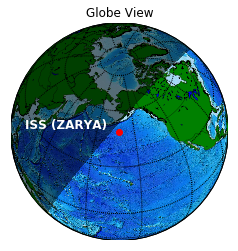

In [7]:
#The 3D Globe map
#Map perspective is set from the current lat/long of the satellite.
fig = plt.figure(1)
map = Basemap(projection='ortho',lon_0=ylongr,lat_0=ylattr,resolution='l')
map.etopo() #Sets the graphics for the globe, different options on basemap site
map.drawcoastlines(linewidth=0.25)
map.drawcountries(linewidth=0.25)
map.fillcontinents(color='green',lake_color='blue')
map.drawmapboundary(fill_color='aqua')
map.drawmeridians(np.arange(0,360,30))
map.drawparallels(np.arange(-90,90,30))

#This part plots the satellite as a red dot and with text, needs direct input of lonlat
sat_lon,sat_lat=map(ylongr,ylattr) #Converts strings to integers for Basemap requirement
map.plot(sat_lon,sat_lat,marker='o',color='r') #Plots the red dot based on sat_lon and sat_lat
plt.text(sat_lon,sat_lat, name,fontsize=12,fontweight='bold',ha='right',va='bottom',color='w') #Plots name of object

#Paints the generic grid on Earth and the penumbra distinguishing between night and day.
nlats = 73; nlons = 145; delta = 2.*np.pi/(nlons-1)
lats = (0.5*np.pi-delta*np.indices((nlats,nlons))[0,:,:])
lons = (delta*np.indices((nlats,nlons))[1,:,:])
wave = 0.75*(np.sin(2.*lats)**8*np.cos(4.*lons))
mean = 0.5*np.cos(2.*lats)*((np.sin(2.*lats))**2 + 2.)
x, y = map(lons*180./np.pi, lats*180./np.pi)
date = datetime.utcnow()
CS=map.nightshade(date)
plt.title('Globe View') 
plt.show()
plt.savefig('Globeview.png') #Save the file for later usage

## 2D Flat map

I then proceed to construct a 2D cylindrical Earth projection. This map is relatively simple in comparison to the 3D Globe, as the observation point is always centered. Same as earlier, the longitude and latitude of the satellite has to be converted into a new set of integers for it to work. These had to be different of the previous sat_lon & sat_lat, or Basemap would protest. These coordinates are then plotted on the map as red dot, just as seen above.

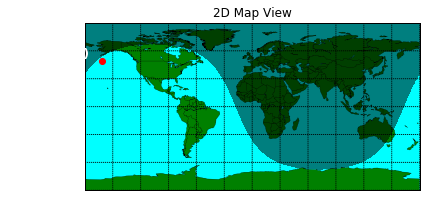

In [8]:
fig = plt.figure(2)
map = Basemap(projection='cyl')
map.drawcoastlines(linewidth=0.25)
map.drawcountries(linewidth=0.25)
map.fillcontinents(color='green',lake_color='aqua')
map.drawmapboundary(fill_color='aqua')
map.drawmeridians(np.arange(0,360,30))
map.drawparallels(np.arange(-90,90,30))

#Need to convert the string with lat/long to an integer for flat map to work
ylongri=int(ylongr);
ylattri=int(ylattr);
sat_lon,sat_lat=map(ylongri,ylattri)
map.plot(sat_lon,sat_lat,marker='o',color='r')
plt.text(sat_lon,sat_lat,name,fontsize=12,fontweight='bold',ha='right',va='bottom',color='w')
date = datetime.utcnow()
CS=map.nightshade(date)
plt.title('2D Map View')
plt.show()
plt.savefig('MercatorView.png') #Save the file for later usage

# 3. Obtaining real satellite data

This part utilizes the opensource weather map from openweathermap.org and Google Earth Imagery. In order for python to access these website and the images, a work around had to be deployed, as images can't be extracted directly from this website. This is done by adding the Google Chrome Webdriver executeable file to a PATH that python recognizes. It's own "bin" directory should suffice. Now with a working webdriver. This code will launch a temporary browser window, which accesses a most current weathermap and Google Earth, for the region specified by satellite's current longitude and latitude. This is added straight into the URL command. I've also defined a standard zoom level at 7 for the weathermap, as it is reasonable for identifying the region and current weather patterns. The window lasts for 8 seconds, as a buffer in case of periods with slow load times. However most of the time 3-4 seconds are sufficient. The browser window is then screenshotted saved as the image "currentweather.png". The browser then shuts itself back down. 

Note:

If the image at times appears incomplete with purple streaks, its due to the lack of weather images in the current region. 

## Generating weather image

In [9]:
#%% Adding weather client from openweathermap.org
#Chromedriver must be installed on system in a path that python can recognize - https://sites.google.com/a/chromium.org/chromedriver/home

#Convert to string for URL usage
sat_latstr=str(sat_lat)
sat_lonstr=str(sat_lon)

#Uses google chrome client to screenshot the current weather data at the location - Ignore the window that opens.
browser = webdriver.Chrome()
url=('http://openweathermap.org/weathermap?basemap=satellite&cities=false&layer=precipitation&lat='+sat_latstr+'=&lon='+sat_lonstr+'&zoom=7')
browser.get(url)
time.sleep(8)             #Give it some time to load the images
browser.save_screenshot('currentweather.png')
browser.quit()


I then proceed to crop the image in order to reduce as much junk and clutter as possible. I save this file as "currentweathercropped.png"

Note: If the images arent cropped properly, there might be issues with your PIL library access to the img.crop command. I have it succesfully tested on both Ubuntu and Windows.

In [10]:
#%% Crops image
img = Image.open('currentweather.png') # uses PIL library to open image in memory
half_the_width = img.size[0] / 2
half_the_height = img.size[1] / 2
img4 = img.crop(
    (
        half_the_width - 929/2,
        half_the_height - 620/2,
        half_the_width + 890/2,
        half_the_height + 884/2
    )
)
img4.save("currentweathercropped.png")


## Generating Google Earth Image

Now for the final image, I repeat the procedure but with a Google Earth map. This map better for determining what the region would look like, if there was no clouds. The image zoom is set to 8, as it corresponds to 7 on the previous map. As this webpage loads faster, I've set the load time to a shorter value. Once complete, the image is stored as "GECurrent.png"

In [11]:
#%% Adding google maps satellite view of area and screenshotting it.
browser2 = webdriver.Chrome()
zoomlevel=str(8)
url2=('http://www.google.com/maps/@'+sat_latstr+','+sat_lonstr+','+zoomlevel+'z/data=!3m1!1e3') 

browser2.get(url2)
time.sleep(5)             #Give it some time to load the images
browser2.save_screenshot('GECurrent.png')
browser2.quit()

Again I crop the map, removing unwanted clutter and save it as "GECurrentcropped.png"

Note: If the images arent cropped properly, there might be issues with your PIL library access to the img.crop command. I have it succesfully tested on both Ubuntu and Windows.

In [12]:
#%% Crops image
img = Image.open('GECurrent.png') # uses PIL library to open image in memory
half_the_width = img.size[0] / 2
half_the_height = img.size[1] / 2
img4 = img.crop(
    (
        half_the_width - 929/2,
        half_the_height - 660/2,
        half_the_width + 929/2,
        half_the_height + 888/2
    )
)
img4.save("GECurrentcropped.png")


As a last modification, I reduce the images to a basewidth of 380 pixel and scale their heights proportionally

In [13]:
#%% Resize images smaller
basewidth = 380 #Sets the basewidth we desire
img = Image.open('currentweathercropped.png') #Opens the already cropped weather map
wpercent = (basewidth/float(img.size[0]))
hsize = int((float(img.size[1])*float(wpercent)))
img = img.resize((basewidth,hsize), Image.ANTIALIAS)
img.save('currentweathercroppedsmall.png') #Saves the resized image as a smaller version

basewidth = 380 #Sets the basewidth we desire
img = Image.open('GECurrentcropped.png') #Opens the already cropped Google Earth map
wpercent = (basewidth/float(img.size[0]))
hsize = int((float(img.size[1])*float(wpercent)))
img = img.resize((basewidth,hsize), Image.ANTIALIAS)
img.save('GECurrentcroppedsmall.png') #Saves the resized image as a smaller version

## 4. Building the Graphical User Interface

I've used the tkinter module for building the GUI. It is setup with a headline, followed by a textbox with all relevant information and finally by the 4 images previous obtained. Then at the bottom there is a Refresh key, that will close the window and re-initialize the script in order to extra the newest information.

Note: Tkinter has a lot of issues with python 2.6. If errors in relation to pyximage occurs, the program needs to be shut down and run again. Then it works flawlessly.

In [14]:
#%% GUI Interface

import Tkinter as tk
from tkFont import Font
from PIL import ImageTk, Image
from Tkinter import END
#Converting information from floats to strings
alt=str(altitude)
vel=str(velocity/1000)
spat=str(((tle_rec.elevation/1000)/650)*60)
space='  '; #Unelegant method for spacing the lines

#This creates the main window of an application
window = tk.Tk()
window.title("Sat Track")
window.geometry("1200x900")
window.configure(background='#f0f0f0')

      
#Imports the pictures.
pic1 = "Globeview.png"
pic2 = "MercatorView.png"
pic3 = "currentweathercroppedsmall.png"
pic4 = "GECurrentcroppedsmall.png"

#Creates a Tkinter-compatible photo image, which can be used everywhere Tkinter expects an image object.
img1 = ImageTk.PhotoImage(Image.open(pic1))
img2 = ImageTk.PhotoImage(Image.open(pic2))
img3 = ImageTk.PhotoImage(Image.open(pic3))
img4 = ImageTk.PhotoImage(Image.open(pic4))

header = tk.Label(window, text="Aarhus University Satellite Control Center", font=Font(size=40))
header.pack()

toprow = tk.Frame(window)
infobox = tk.Text(toprow, width=50, height=7, font=("Calibri",12))
infobox.pack(side = "left") 
infobox.insert(END,"Current information for:"+space+name +'\n'+
               "Time:" +space+times+ '\n'+
               "Longitude:"+space +x_long+ '\n'+
               "Latitude:" +space+x_lat+ '\n'+     
               "Altitude:" +space+alt+space+ "[km]"+'\n'+
               "Velocity:" +space+vel+space+ "[km/s]" + '\n'+
               "Spatial Resolution: "+space +spat+space+ "[Pixels pr. m]"
               )
toprow.pack()

midrow = tk.Frame(window)
globeview = tk.Label(midrow, image = img1)
globeview.pack(side = "left") # the side argument sets this to pack in a row rather than a column
mercatorview = tk.Label(midrow, image = img2)
mercatorview.pack(side = "left")
midrow.pack() # pack the toprow frame into the window 

bottomrow = tk.Frame(window)
currentweather= tk.Label(bottomrow, image = img3)
currentweather.pack(side = "left")
gearth = tk.Label(bottomrow, image = img4)
gearth.pack(side = "left")
bottomrow.pack()

bottomtext = tk.Frame(window)
currentweather1 = tk.Label(bottomtext, text="Current Weather")
currentweather1.pack(side = "left")
spacers = tk.Label(bottomtext, text="                                                                                  ")
spacers.pack(side="left")
gearth1 = tk.Label(bottomtext, text="Google Earth Image")
gearth1.pack(side = "left")
bottomtext.pack()

def RefreshAction():
    execfile("SatTracker.py")

def CloseWindow():
    window.destroy()

button = tk.Frame(window)
button = tk.Button(text='Refresh Data', width=25,command=lambda:[CloseWindow(),RefreshAction()])
button.pack()

window.mainloop()

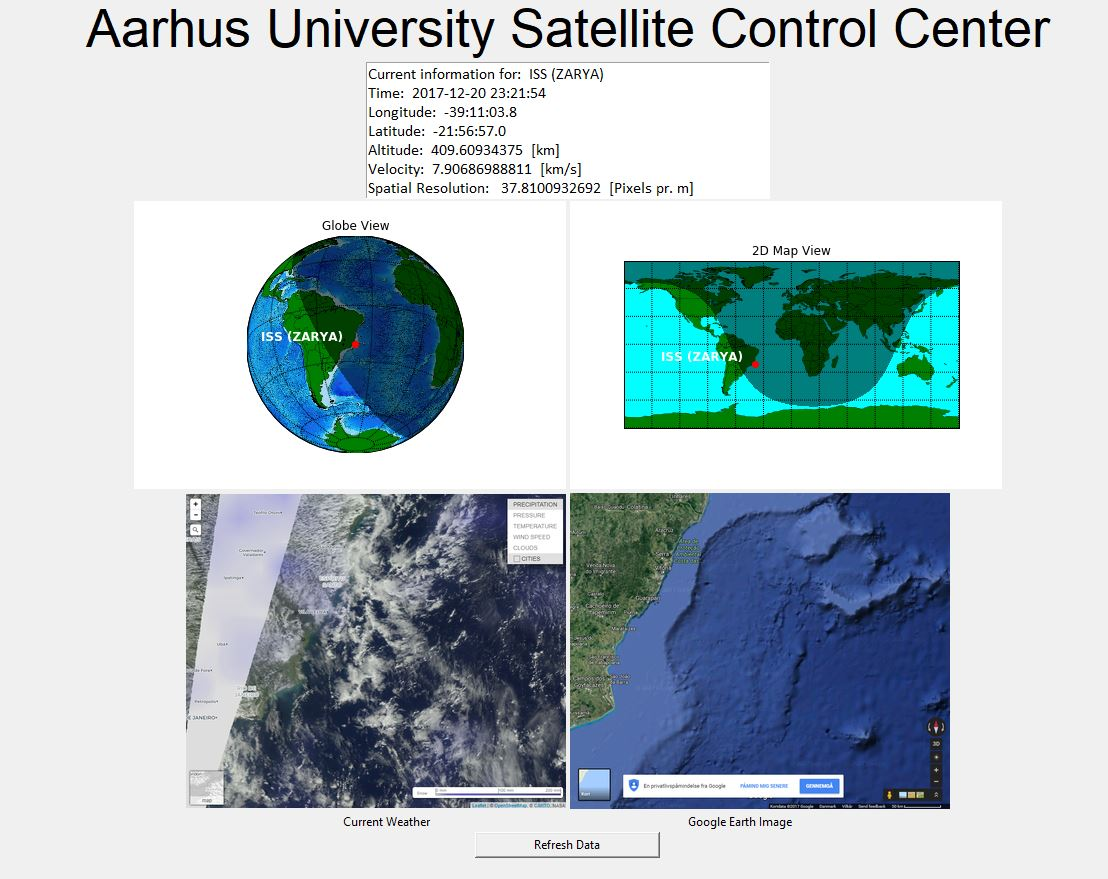

(The picture of the GUI is taken at a different time and thus doesn't correspond to the images above which was run at a different time)'